In [ ]:
#Import Library yang dibutuhkan
import yfinance as yf
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
# Mute general warnings
import warnings
warnings.filterwarnings('ignore')

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Dropout,Dense
from tensorflow.keras.optimizers import Adamax

In [ ]:
#download datset ticker untuk saham Bank BCA dari yahoo finance
#download datset ticker untuk saham Bank BCA dari yahoo finance
df = pd.read_csv("BBCA.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-05,2195.0,2200.0,2195.0,2195.0,1859.476929,15491000
1,2014-05-06,2200.0,2225.0,2195.0,2200.0,1863.712402,16333000
2,2014-05-07,2200.0,2220.0,2190.0,2200.0,1863.712402,35320000
3,2014-05-08,2235.0,2240.0,2190.0,2210.0,1872.184204,30284000
4,2014-05-09,2190.0,2240.0,2190.0,2240.0,1897.598389,33977000
...,...,...,...,...,...,...,...
2001,2024-05-30,9000.0,9250.0,8775.0,9000.0,9000.000000,207115100
2002,2024-05-31,9100.0,9250.0,9025.0,9250.0,9250.000000,756431600
2003,2024-06-03,9350.0,9350.0,9225.0,9275.0,9275.000000,72197700
2004,2024-06-04,9525.0,9525.0,9350.0,9350.0,9350.000000,75353100


In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2006 non-null   object 
 1   Open       2006 non-null   float64
 2   High       2006 non-null   float64
 3   Low        2006 non-null   float64
 4   Close      2006 non-null   float64
 5   Adj Close  2006 non-null   float64
 6   Volume     2006 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 109.8+ KB


In [ ]:
#mengecek missing value
df.isnull().values.any()

False

In [ ]:
# Asumsi 'df' adalah dfFrame dengan kolom 'Open', 'High', 'Low', 'Close', 'Volume', dan indeks tanggal
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Harga Saham (OHLC)", "Volume Perdagangan"))

# Menambahkan trace OHLC
fig.add_trace(go.Ohlc(x=df.index,
                      open=df['Open'],
                      high=df['High'],
                      low=df['Low'],
                      close=df['Close'],
                      name='Harga'), row=1, col=1)

# Menambahkan trace Volume
fig.add_trace(go.Scatter(x=df.index, y=df['Volume'], name='Volume'), row=2, col=1)

# Memperbarui layout untuk menyembunyikan range slider pada sumbu x
fig.update(layout_xaxis_rangeslider_visible=False)

# Memperbarui layout untuk menambahkan judul utama
fig.update_layout(title_text="Analisis Saham dan Volume Perdagangan")

# Menampilkan figure
fig.show()

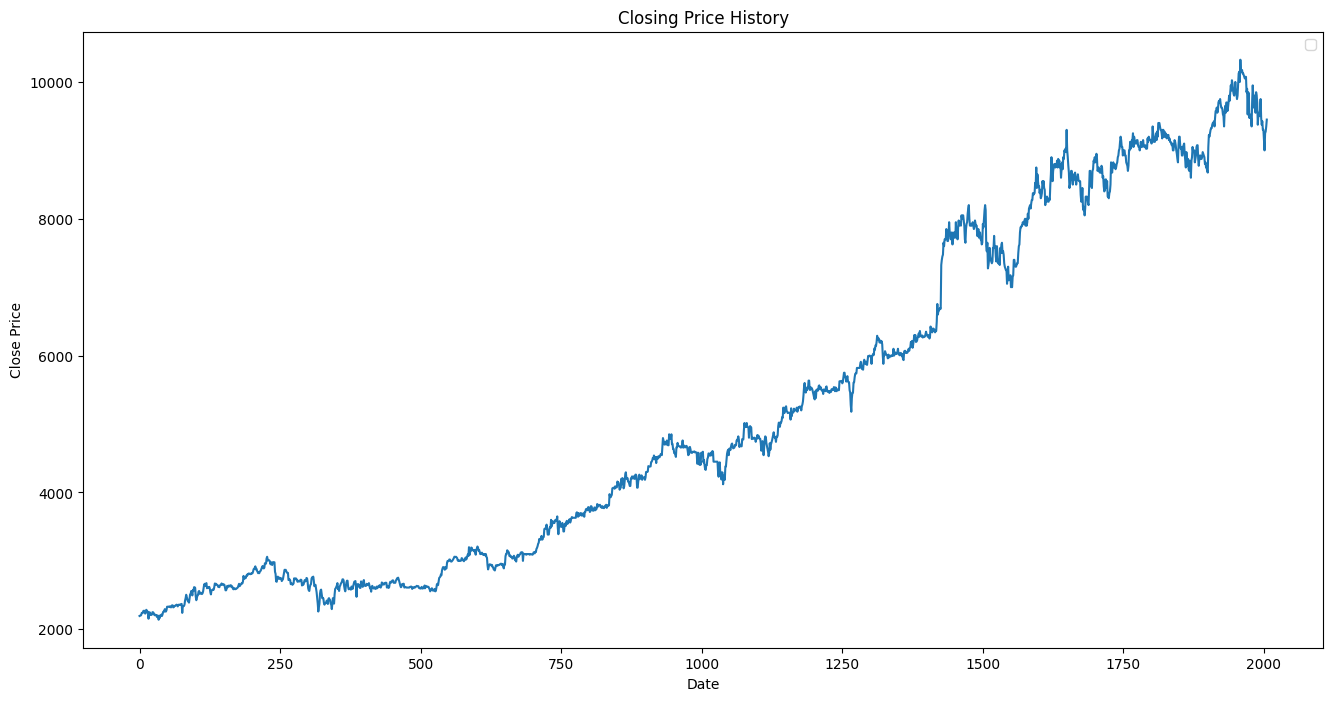

In [ ]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(df['Close'])
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
# Plot all prices
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Opening Price', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low Price', line=dict(color='black')))
fig.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High Price', line=dict(color='blue')))

fig.update_layout(
    title='Stock Price History',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

# Plot subplots for each individual price
fig_subplots = make_subplots(rows=2, cols=2, subplot_titles=('Opening Price', 'Closing Price', 'Low Price', 'High Price'))

fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Opening Price', line=dict(color='red')), row=1, col=1)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price', line=dict(color='green')), row=1, col=2)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low Price', line=dict(color='black')), row=2, col=1)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High Price', line=dict(color='blue')), row=2, col=2)

fig_subplots.update_layout(title='Stock Price Subplots', showlegend=False)

fig.show()
fig_subplots.show()

In [ ]:
#Melihat harga penutupan dan harga terendah
df.iloc[:, 2:-1].describe()

,High,Low,Close,Adj Close
count,2006.000000,2006.000000,2006.000000,2006.000000
mean,5241.510469,5157.637089,5200.366401,4779.901429
std,2498.530303,2461.862979,2480.773561,2518.078168
min,2190.000000,2140.000000,2140.000000,1812.884155
25%,2875.000000,2820.000000,2850.000000,2428.560852
50%,4637.500000,4580.000000,4595.000000,4077.838867
75%,7793.750000,7650.000000,7700.000000,7251.828613
max,10400.000000,10150.000000,10325.000000,10092.431641


# Normalisasi

In [ ]:
#Memilih Harga Penutupan (Closing Price) dan mengkonvesi menjadi aray 2D
close_prices = df['Close'].values.reshape(-1, 1)

#Normalisasi df menggunakan Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaler = scaler.fit_transform(close_prices)

In [ ]:
data_norm = pd.DataFrame(df_scaler)
data_norm

,0
0,0.006720
1,0.007330
2,0.007330
3,0.008552
4,0.012217
...,...
2001,0.838119
2002,0.868662
2003,0.871717
2004,0.880880


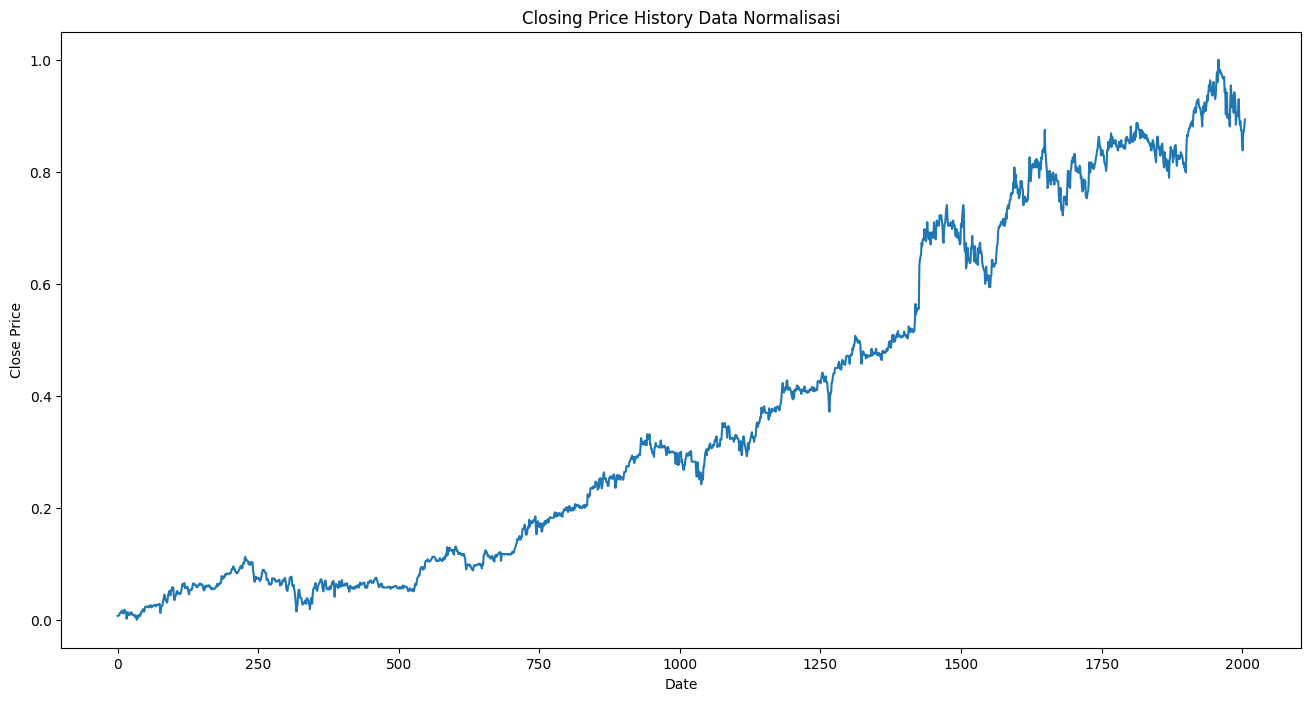

In [ ]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History Data Normalisasi")
plt.plot(df_scaler)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [ ]:
# Data preparation
def create_df(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        lag_values = data[i:(i + time_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + time_steps, 0]]]))
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# SPLIT DATA

In [ ]:
# Extract original and scaled close prices
# Calculate statistics
original_stats = pd.Series(df['Close'].values).describe()
scaled_stats = pd.Series(df_scaler.flatten()).describe()

# Print the summary
print("Original Close Prices Statistics:")
print(original_stats)

print("\nScaled Close Prices Statistics:")
print(scaled_stats)

Original Close Prices Statistics:
count     2006.000000
mean      5200.366401
std       2480.773561
min       2140.000000
25%       2850.000000
50%       4595.000000
75%       7700.000000
max      10325.000000
dtype: float64

Scaled Close Prices Statistics:
count    2006.000000
mean        0.373899
std         0.303088
min         0.000000
25%         0.086744
50%         0.299939
75%         0.679291
max         1.000000
dtype: float64


In [ ]:
time_steps = 120
X, y = create_df(df_scaler, time_steps)

In [ ]:
# Splitting into train, test, and validation sets
train_size = int(len(X) * 0.8)
test_size = int(len(X) * 0.1)
validation_size = len(X) - train_size - test_size

X_train, X_test, X_val = X[:train_size], X[train_size:train_size + test_size], X[train_size + test_size:]
y_train, y_test, y_val = y[:train_size], y[train_size:train_size + test_size], y[train_size + test_size:]

In [ ]:
# Print shapes of the datasets
print("Shapes of the datasets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Shapes of the datasets:
X_train: (1508, 121), y_train: (1508,)
X_test: (188, 121), y_test: (188,)
X_val: (190, 121), y_val: (190,)


# Data Train

In [ ]:
data_train =  pd.DataFrame(df_scaler[:train_size])

print(f"Data Train")
data_train

Data Train


,0
0,0.006720
1,0.007330
2,0.007330
3,0.008552
4,0.012217
...,...
1503,0.731216
1504,0.740379
1505,0.731216
1506,0.667074


# Data Test

In [ ]:
data_test = pd.DataFrame(df_scaler[train_size:train_size + test_size])

print(f"Data Test")
data_test

Data Test


,0
0,0.673183
1,0.627367
2,0.633476
3,0.642639
4,0.664020
...,...
183,0.801466
184,0.773977
185,0.777031
186,0.770922


# Data Validation

In [ ]:
data_validation = pd.DataFrame(df_scaler[train_size + test_size:train_size + test_size + validation_size])

print(f"Data Validation")
data_validation

Data Validation


,0
0,0.804520
1,0.819792
2,0.816738
3,0.825901
4,0.816738
...,...
185,0.847282
186,0.847282
187,0.822847
188,0.810629


#Hyperparameter

In [ ]:
# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_gru = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [ ]:
#Define hyperparameter search space
space = {
    'units': hp.choice('units', [50, 100, 150]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning rate', np.log(0.001), np.log(0.01)),
    'epochs': hp.choice('epochs', [50, 100, 150, 200]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Create a function to build and train the model with hyperparameters
from tensorflow.keras.optimizers import Adamax

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a function to build and train the model with hyperparameters
def objective(params, model_type, X_train, y_train, X_val, y_val):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred)
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))

    mse = mean_squared_error(y_val_orig, y_pred)
    return {'loss': mse, 'status': 'ok', 'params': params}

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for LSTM and GRU
best_lstm = fmin(fn=lambda params: objective(params, 'lstm', X_train_lstm, y_train, X_val_lstm, y_val),
                 space=space, algo=tpe.suggest, max_evals=20, trials=trials_lstm)

best_gru = fmin(fn=lambda params: objective(params, 'gru', X_train_gru, y_train, X_val_gru, y_val),
                space=space, algo=tpe.suggest, max_evals=20, trials=trials_gru)

6/6 [==============================] - 2s 54ms/step

6/6 [==============================] - 2s 207ms/step

6/6 [==============================] - 2s 86ms/step

6/6 [==============================] - 2s 215ms/step

6/6 [==============================] - 2s 92ms/step

6/6 [==============================] - 2s 93ms/step

6/6 [==============================] - 2s 216ms/step

6/6 [==============================] - 2s 111ms/step

6/6 [==============================] - 2s 97ms/step

6/6 [==============================] - 2s 214ms/step

6/6 [==============================] - 1s 55ms/step

6/6 [==============================] - 3s 259ms/step

6/6 [==============================] - 2s 96ms/step

6/6 [==============================] - 1s 54ms/step

6/6 [==============================] - 2s 94ms/step

6/6 [==============================] - 3s 378ms/step

6/6 [==============================] - 2s 212ms/step

6/6 [==============================] - 2s 96ms/step

6/6 [==============================] -

In [ ]:
import math
from hyperopt import hp, fmin, tpe, Trials, space_eval
import tensorflow as tf

In [ ]:
# Extract results for LSTM
results_lstm = []
for trial in trials_lstm.trials:
    mse = trial['result']['loss']
    params = trial['result']['params']
    rmse = math.sqrt(mse)
    results_lstm.append({**params, 'mse': mse, 'rmse': rmse})

# Convert results to DataFrame
df_lstm = pd.DataFrame(results_lstm)

# Display the DataFrames
print("LSTM Hyperparameter Results:")
print(df_lstm)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)
# Display the best hyperparameters
print("\nBest Hyperparameters for LSTM:")
print(best_params_lstm)

LSTM Hyperparameter Results:
    batch_size  dropout_rate  epochs  learning_rate  units           mse  \
0           64      0.202927     200       0.008554     50  54964.461121   
1           64      0.499952      50       0.001360    150  37655.112745   
2           32      0.447709     150       0.007450     50  38116.522941   
3          128      0.329358     150       0.007527    150  41560.526818   
4           64      0.266529      50       0.003788    100  35858.430554   
5           64      0.321611     100       0.007455    100  41494.913795   
6           32      0.218393     200       0.002803    150  22382.636334   
7           32      0.457314     150       0.004089    100  44464.238533   
8          128      0.440496     200       0.001409    100  44060.237663   
9           32      0.304214     100       0.001592    150  40411.484994   
10         128      0.236357     200       0.008239     50  41160.280483   
11          64      0.489207     100       0.002794    150 

In [ ]:
# Extract results for GRU
results_gru = []
for trial in trials_gru.trials:
    mse = trial['result']['loss']
    params = trial['result']['params']
    rmse = math.sqrt(mse)
    results_gru.append({**params, 'mse': mse, 'rmse': rmse})


# Convert results to DataFrame
df_gru = pd.DataFrame(results_gru)

# Display the DataFrames
print("\nGRU Hyperparameter Results:")
print(df_gru)

# Get the best hyperparameters from the optimization results
best_params_gru = space_eval(space, best_gru)

# Display the best hyperparameters
print("\nBest Hyperparameters for GRU:")
print(best_params_gru)


GRU Hyperparameter Results:
    batch_size  dropout_rate  epochs  learning_rate  units           mse  \
0           32      0.283950      50       0.006000    100  20008.277378   
1          128      0.253562     200       0.002579    100  17393.568912   
2           32      0.242783     200       0.004688    100   6674.562614   
3          128      0.304331     200       0.002116    150  16968.043288   
4          128      0.320508     200       0.003096    150  15999.441053   
5           32      0.481869      50       0.006297    150  15563.565613   
6          128      0.262331     150       0.003240    100  19766.137806   
7           32      0.331957     200       0.007409    100  16293.230618   
8          128      0.392560     100       0.005823    100  18326.039343   
9          128      0.466005      50       0.002735    150  17580.307531   
10          32      0.479917     100       0.002947    100  27860.974947   
11         128      0.340582     100       0.002033    100 

In [ ]:
# Build the final LSTM model using the best hyperparameters
final_model_lstm = Sequential([
    LSTM(units=best_params_lstm['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units'], return_sequences=True),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units']),
    Dense(units=1)
])

final_model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

# Train the final LSTM model
history_lstm = final_model_lstm.fit(X_train_lstm, y_train, epochs=best_params_lstm['epochs'],
                                    batch_size=best_params_lstm['batch_size'], verbose=2,
                                    validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])

Epoch 1/100
48/48 - 22s - loss: 0.0050 - val_loss: 6.2320e-04 - 22s/epoch - 450ms/step
Epoch 2/100
48/48 - 17s - loss: 4.5165e-04 - val_loss: 0.0020 - 17s/epoch - 364ms/step
Epoch 3/100
48/48 - 14s - loss: 4.6878e-04 - val_loss: 0.0020 - 14s/epoch - 300ms/step
Epoch 4/100
48/48 - 14s - loss: 4.7109e-04 - val_loss: 0.0047 - 14s/epoch - 298ms/step
Epoch 5/100
48/48 - 15s - loss: 5.0401e-04 - val_loss: 0.0021 - 15s/epoch - 305ms/step
Epoch 6/100
48/48 - 15s - loss: 4.8967e-04 - val_loss: 0.0017 - 15s/epoch - 304ms/step
Epoch 7/100
48/48 - 15s - loss: 3.5413e-04 - val_loss: 0.0012 - 15s/epoch - 305ms/step
Epoch 8/100
48/48 - 15s - loss: 4.2210e-04 - val_loss: 0.0012 - 15s/epoch - 303ms/step
Epoch 9/100
48/48 - 15s - loss: 3.8153e-04 - val_loss: 5.8358e-04 - 15s/epoch - 306ms/step
Epoch 10/100
48/48 - 15s - loss: 4.8577e-04 - val_loss: 0.0020 - 15s/epoch - 304ms/step
Epoch 11/100
48/48 - 15s - loss: 5.4404e-04 - val_loss: 5.6517e-04 - 15s/epoch - 310ms/step
Epoch 12/100
48/48 - 15s - loss: 

In [ ]:
# Build the final GRU model using the best hyperparameters
final_model_gru = Sequential([
    GRU(units=best_params_gru['units'], return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units'], return_sequences=True),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units']),
    Dense(units=1)
])

final_model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

# Train the final GRU model
history_gru = final_model_gru.fit(X_train_gru, y_train, epochs=best_params_gru['epochs'],
                                  batch_size=best_params_gru['batch_size'], verbose=2,
                                  validation_data=(X_val_gru, y_val), callbacks=[early_stopping])

Epoch 1/200
48/48 - 21s - loss: 0.0052 - val_loss: 4.1477e-04 - 21s/epoch - 434ms/step
Epoch 2/200
48/48 - 14s - loss: 4.1964e-04 - val_loss: 6.3819e-04 - 14s/epoch - 282ms/step
Epoch 3/200
48/48 - 14s - loss: 5.1974e-04 - val_loss: 2.8674e-04 - 14s/epoch - 282ms/step
Epoch 4/200
48/48 - 14s - loss: 3.8575e-04 - val_loss: 9.1875e-04 - 14s/epoch - 282ms/step
Epoch 5/200
48/48 - 13s - loss: 3.5979e-04 - val_loss: 0.0019 - 13s/epoch - 280ms/step
Epoch 6/200
48/48 - 13s - loss: 3.3149e-04 - val_loss: 6.4219e-04 - 13s/epoch - 276ms/step
Epoch 7/200
48/48 - 14s - loss: 2.4936e-04 - val_loss: 2.9611e-04 - 14s/epoch - 283ms/step
Epoch 8/200
48/48 - 14s - loss: 2.6235e-04 - val_loss: 3.5324e-04 - 14s/epoch - 292ms/step
Epoch 9/200
48/48 - 14s - loss: 2.1664e-04 - val_loss: 3.5031e-04 - 14s/epoch - 282ms/step
Epoch 10/200
48/48 - 14s - loss: 3.0467e-04 - val_loss: 0.0019 - 14s/epoch - 286ms/step
Epoch 11/200
48/48 - 13s - loss: 2.4822e-04 - val_loss: 4.2279e-04 - 13s/epoch - 280ms/step
Epoch 12/

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Model evaluation for LSTM
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_orig_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_orig_lstm, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_orig_lstm, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_orig_lstm - y_pred_lstm) / y_test_orig_lstm)) * 100

# Display results for LSTM
print("Performance Metrics for LSTM:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

# Model evaluation for GRU
y_pred_gru = final_model_gru.predict(X_test_gru)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_orig_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for GRU
mse_gru = mean_squared_error(y_test_orig_gru, y_pred_gru)
rmse_gru = math.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test_orig_gru, y_pred_gru)
mape_gru = np.mean(np.abs((y_test_orig_gru - y_pred_gru) / y_test_orig_gru)) * 100

# Display results for GRU
print("Performance Metrics for GRU:")
print("Mean Squared Error (MSE):", mse_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("Mean Absolute Error (MAE):", mae_gru)
print("Mean Absolute Percentage Error (MAPE):", mape_gru)

6/6 [==============================] - 2s 91ms/step
Performance Metrics for LSTM:
Mean Squared Error (MSE): 4198.806013798457
Root Mean Squared Error (RMSE): 64.79819452576173
Mean Absolute Error (MAE): 51.461433572972055
Mean Absolute Percentage Error (MAPE): 0.5913220975249067
6/6 [==============================] - 2s 70ms/step
Performance Metrics for GRU:
Mean Squared Error (MSE): 15317.612633390625
Root Mean Squared Error (RMSE): 123.7643431420804
Mean Absolute Error (MAE): 96.16545462101062
Mean Absolute Percentage Error (MAPE): 1.1034250765824805


In [ ]:
# Visualize predictions for the final LSTM model
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_test_orig_lstm.flatten(),
                         mode='lines',
                         name="Actual Stock Prices",
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_pred_lstm.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (LSTM)",
                         line=dict(color='red')))

# Visualize predictions for the final GRU model
fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_pred_gru.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (GRU)",
                         line=dict(color='orange')))

fig.update_layout(title="Stock Price Prediction (LSTM vs GRU)",
                  xaxis_title="Date",
                  yaxis_title="Stock Price (IDR)",
                  template='plotly_dark',
                  legend=dict(orientation="h", yanchor="bottom",y=1.02, xanchor="right",x=1))

fig.show()

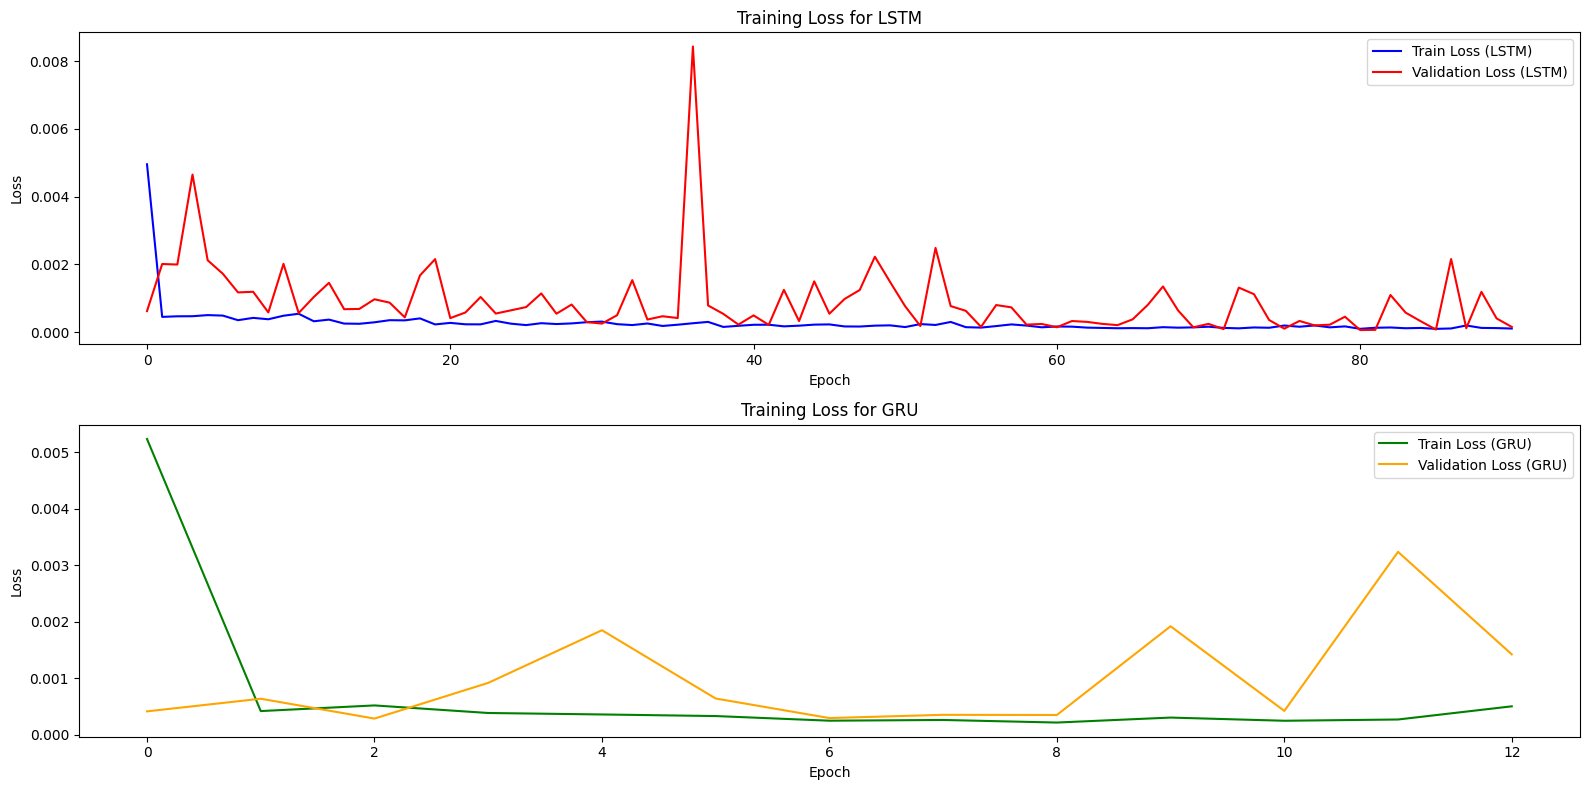

In [ ]:
# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [ ]:
actual_values = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)), columns=['Actual'])
lstm_predictions = pd.DataFrame(y_pred_lstm, columns=['LSTM Prediction'])
gru_predictions = pd.DataFrame(y_pred_gru, columns=['GRU Prediction'])

# Combining into a single DataFrame
results_df = pd.concat([actual_values, lstm_predictions, gru_predictions], axis=1)
results_df

,Actual,LSTM Prediction,GRU Prediction
0,8800.0,8821.124023,8734.995117
1,8750.0,8809.659180,8757.115234
2,8800.0,8820.549805,8775.780273
3,8775.0,8816.790039,8789.061523
4,8850.0,8850.692383,8806.607422
...,...,...,...
183,9200.0,9241.871094,9243.497070
184,9400.0,9329.092773,9268.083008
185,9400.0,9380.070312,9300.892578
186,9400.0,9398.290039,9332.441406


In [ ]:
# Function to make future predictions using GRU model
def predict_future(model, data, n_steps, n_days):
    predictions = []
    current_input = data[-n_steps:].reshape((1, n_steps, 1))

    for _ in range(n_days):
        next_prediction = model.predict(current_input)
        predictions.append(next_prediction[0, 0])
        current_input = np.append(current_input[:, 1:, :], next_prediction.reshape((1, 1, 1)), axis=1)

    return np.array(predictions)

# Assuming the final GRU model and scaler are already defined and trained
n_days = 30  # Number of days to predict
future_predictions = predict_future(final_model_gru, df_scaler, time_steps , n_days)

# Inverse transform the predictions to get actual stock prices
future_predictions_actual = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Creating a DataFrame for the future predictions with numbering
future_predictions_df = pd.DataFrame({'GRU Prediction': future_predictions_actual.flatten()},
                                     index=np.arange(1, len(future_predictions_actual) + 1))

# Display the table
future_predictions_df

1/1 [==============================] - 0s 41ms/step


,GRU Prediction
1,9354.330078
2,9373.515625
3,9386.551758
4,9396.399414
5,9405.265625
6,9414.035156
7,9422.848633
8,9431.625000
9,9440.299805
10,9448.854492


In [ ]:
# Generate index for the future dates (numbering)
future_dates = np.arange(len(df_scaler), len(df_scaler) + n_days)

# Extract dates for actual data
actual_dates = pd.date_range(start='2008-05-05', periods=len(df_scaler), freq='B')
# Plot using Plotly
fig = go.Figure()

# Add actual stock prices trace
fig.add_trace(go.Scatter(x=actual_dates,
                         y=scaler.inverse_transform(df_scaler.flatten().reshape(-1, 1)).flatten(),
                         mode='lines',
                         name='Actual Stock Prices',
                         line=dict(color='blue')))

# Add future predictions trace
fig.add_trace(go.Scatter(x=pd.date_range(start=actual_dates[-1], periods=n_days + 1, freq='B')[1:],
                         y=future_predictions_actual.flatten(),
                         mode='lines',
                         name='Future Predictions (GRU)',
                         line=dict(color='orange', dash='dot')))

fig.update_layout(title='Stock Price Prediction for Next Month (GRU)',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (IDR)',
                  template='plotly_dark',
                  legend=dict(x=0.5, y=1, xanchor='left', yanchor='bottom', orientation='h'))

fig.show()